# [Blog title]
Hiro Naito

## Preps

In [2]:
# Libraries 

import pandas as pd
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gaussian

from econml.metalearners import SLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
import dowhy
from dowhy import CausalModel
from dowhy import gcm
import networkx as nx

from econml.dml import DML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from econml.metalearners import TLearner

In [3]:
def create_graph(causal_matrix: pd.DataFrame): 
    G = nx.DiGraph()
    G.add_nodes_from(causal_matrix.columns.to_list())
    for i, row in enumerate(causal_matrix.index):
        for j, col in enumerate(causal_matrix.columns):
            weight = causal_matrix.iloc[i, j]
            if weight != 0.0:  # Add an edge only if the weight is non-zero
                G.add_edge(row, col, weight=weight)

    return G

def create_synth_data(G : nx.DiGraph, causal_matrix: pd.DataFrame, n: int, binaries: list[str] = []):
    #Get list of nodes in topolocial order
    topological_sorted = list(nx.topological_sort(G))

    df = pd.DataFrame()
    for node in topological_sorted:
        if node in binaries:
            values = np.zeros(n)
            for predecessor in G.predecessors(node):
                values += df[predecessor] * causal_matrix.at[predecessor,node]
            p = 1 / (1 + np.exp(-1.0 * values))
            values = np.random.binomial(1,p,n)
        else:
            values = np.random.normal(0,1,n)
            for predecessor in G.predecessors(node):
                values += df[predecessor] * causal_matrix.at[predecessor,node]
        df[node] = values
    return df

In [4]:
#Synthetic data size
n = 10000

#Fixing seed
random_state=123

## Part 1 - Mediators

### Simple example with a mediator
__Example scenarios:__
   * __Education: After-School Tutoring__
      * __Treatment (T):__ Enrollment in an after-school tutoring program.
      * __Mediator (M):__ # of hours to study in a week.
      * __Outcome (Y):__  GPA (Grade Point Average).
   * __Mental Health: Cognitive Behavioral Therapy (CBT)__
      * __Treatment (T):__ Joining Cognitive Behavioral Therapy (CBT).
      * __Mediator (M):__ Frequency of negative thought pattern.
      * __Outcome (Y):__ Mental health score from survey.
   * __Marketing: Advertising Campaign__
       * __Treatment (T):__ Exposure to an advertising campaign.
       * __Mediator (M):__ Product awareness.
       * __Outcome (Y):__ Product sales.

In [20]:
# Create causal matrix and create graph + synthetic data based on the matrix

#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 0.0, "M": 2.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "M": 0.0},
    {"node_from": "M", "T": 0.0, "Y": 4.0, "M": 0.0}
])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Create synthetic data with the relationship specified

T = np.random.binomial(1,0.5,n)
M = 2.0 * T + np.random.normal(0,1,n)
Y = 4.0 * M + np.random.normal(0,1,n)

df = pd.DataFrame({'T':T,'M':M,'Y':Y})
df

T         M         Y
0     0 -1.092531 -4.599036
1     1  1.354815  3.530234
2     1  2.239324  9.215082
3     1  0.902585  4.746224
4     0 -0.473381 -1.604116
...  ..       ...       ...
9995  0 -0.599361 -3.275682
9996  0  1.080794  4.296124
9997  0  0.954778  1.672744
9998  0 -0.260759 -1.884517
9999  1  0.741306  1.900472

[10000 rows x 3 columns]

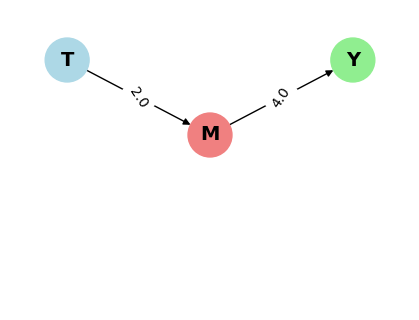

In [22]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M':(0.5,-0.3)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [24]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          16.766
Method:                          IRLS   Log-Likelihood:                -28285.
Date:                Mon, 09 Sep 2024   Deviance:                   1.6763e+05
Time:                        10:26:13   Pearson chi2:                 1.68e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6147
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0075      0.059      0.128      0.8

In [26]:
#Estimate effect by regressing on outcome using both treatment and mediator variable

formula1 = 'Y ~ T + M'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                         0.98260
Method:                          IRLS   Log-Likelihood:                -14100.
Date:                Mon, 09 Sep 2024   Deviance:                       9823.0
Time:                        10:26:15   Pearson chi2:                 9.82e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0057      0.014     -0.403      0.6

### Simple example + adding an arrow T -> Y
__Example scenarios:__
   * __Education: Classroom Technology__
      * __Treatment (T):__ Introduction of interactive technology in the classroom.
      * __Mediator (M):__ Increase in student engagement.
      * __Outcome (Y):__ Improvement in academic performance.
   * __Mental Health: Mental Health: Antidepressant Medication__
      * __Treatment (T):__ Use of antidepressant medication.
      * __Mediator (M):__ Improvement in mood or cognitive function.
      * __Outcome (Y):__ Reduction in depression symptoms.
   * __Economics: Financial Incentive Program__
       * __Treatment (T):__ Provision of financial incentives to workers.
       * __Mediator (M):__  Increase in worker productivity.
       * __Outcome (Y):__ Increase in company profits.

In [132]:
# Create causal matrix and create graph + synthetic data based on the matrix


#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 1.0, "M": 2.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "M": 0.0},
    {"node_from": "M", "T": 0.0, "Y": 4.0, "M": 0.0}
])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)



#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

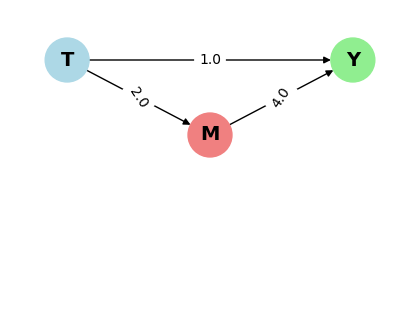

In [134]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M':(0.5,-0.3)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [136]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          16.825
Method:                          IRLS   Log-Likelihood:                -28303.
Date:                Sat, 07 Sep 2024   Deviance:                   1.6821e+05
Time:                        09:11:38   Pearson chi2:                 1.68e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7081
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0036      0.058     -0.062      0.9

In [138]:
#Estimate effect by regressing on outcome using both treatment and mediator variable

formula1 = 'Y ~ T + M'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          1.0077
Method:                          IRLS   Log-Likelihood:                -14226.
Date:                Sat, 07 Sep 2024   Deviance:                       10074.
Time:                        09:11:39   Pearson chi2:                 1.01e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0196      0.014     -1.388      0.1

### Two mediators example
__Example scenarios:__
   * __Economics: Financial Literacy Training__
     * __Treatment (T):__ Participation in a financial literacy training program.
     * __Mediator 1 (M1):__ Improvement in budgeting skills.
     * __Mediator 2 (M2):__ Increase in savings behavior.
     * __Outcome (Y):__ Increase in financial stability.
   * __Public Health: Weight Loss Program__
      * __Treatment (T):__ Enrollment in a weight loss program.
      * __Mediator 1 (M1):__ Increase in physical activity.
      * __Mediator 2 (M2):__ Improvement in dietary habits.
      * __Outcome (Y):__ Reduction in body mass index (BMI).
   * __Marketing: Multi-Channel Advertising Campaign__
      * __Treatment (T):__ Exposure to a multi-channel advertising campaign.
      * __Mediator 1 (M1):__ Increase in brand awareness.
      * __Mediator 2 (M2):__ Improvement in brand perception.
      * __Outcome (Y):__ Increase in product sales

In [141]:
# Create causal matrix and create graph + synthetic data based on the matrix


#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 0.0, "M1": 2.0, "M2": 1.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "M1": 0.0, "M2": 0.0},
    {"node_from": "M1", "T": 0.0, "Y": 4.0, "M1": 0.0, "M2": 0.0},
    {"node_from": "M2", "T": 0.0, "Y": 3.0, "M1": 0.0, "M2": 0.0},

])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

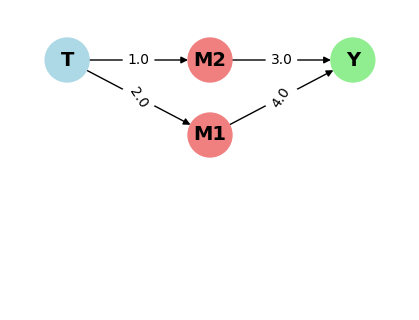

In [143]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M1':(0.5,-0.3), 'M2': (0.5, 0)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [145]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          25.992
Method:                          IRLS   Log-Likelihood:                -30477.
Date:                Sat, 07 Sep 2024   Deviance:                   2.5986e+05
Time:                        09:11:41   Pearson chi2:                 2.60e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6823
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0176      0.073     -0.243      0.8

In [147]:
#Estimate effect by regressing on outcome using both treatment and mediator variables

formula1 = 'Y ~ T + M1 + M2'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9996
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          1.0016
Method:                          IRLS   Log-Likelihood:                -14195.
Date:                Sat, 07 Sep 2024   Deviance:                       10012.
Time:                        09:11:42   Pearson chi2:                 1.00e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.014      0.599      0.5

### Complex example

In [150]:
# Import causal matrix and create graph + synthetic data based on the matrix


causal_matrix = pd.read_csv("Dont add all features - Mediator.csv", index_col=0)
causal_matrix.fillna(0.0,inplace=True)
#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

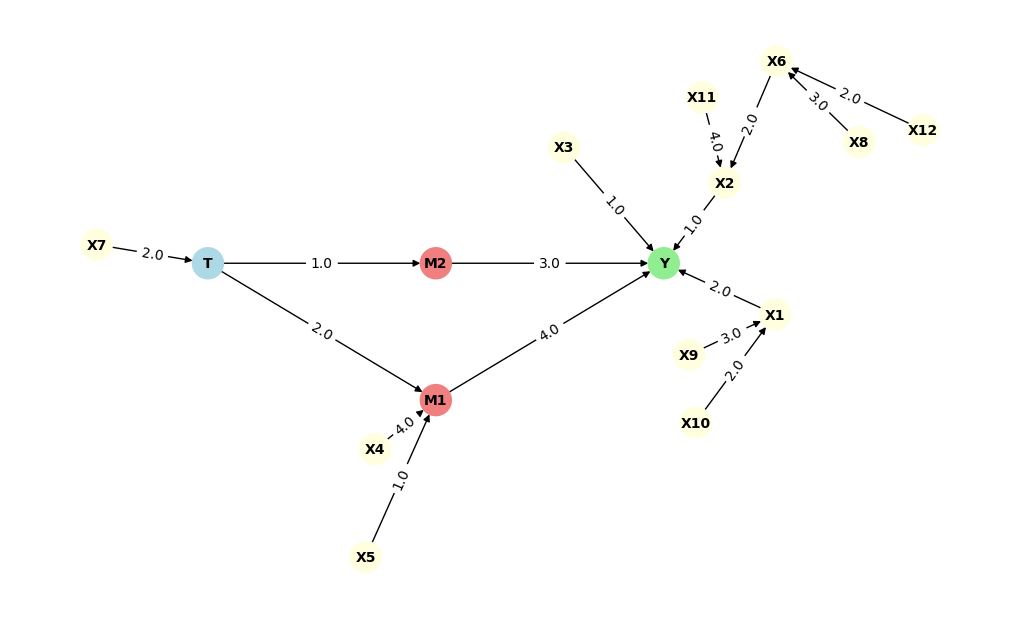

In [152]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M1':(0.5,-0.3), 'M2': (0.5, 0)}
pos = nx.spring_layout(G, k=0.2, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(10,6))
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


#plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
#plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [162]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          425.81
Method:                          IRLS   Log-Likelihood:                -44458.
Date:                Sat, 07 Sep 2024   Deviance:                   4.2573e+06
Time:                        09:12:59   Pearson chi2:                 4.26e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.07158
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1253      0.293     -0.427      0.6

In [164]:
#Estimate effect by regressing on outcome using all variables

formula1 = 'Y ~ T + M1 + M2 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9984
Model Family:                Gaussian   Df Model:                           15
Link Function:               Identity   Scale:                         0.98901
Method:                          IRLS   Log-Likelihood:                -14126.
Date:                Sat, 07 Sep 2024   Deviance:                       9874.2
Time:                        09:13:03   Pearson chi2:                 9.87e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0332      0.016     -2.067      0.0

In [172]:
#Estimate using T-learner and using Random Forest as the underlying model

t_learner = TLearner(models = LGBMRegressor(n_estimators=100, random_state=random_state))


# Split to test & train. Training data includes all features
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(df.drop(columns=['T','Y']), df['T'],df['Y'], test_size=0.2, random_state=random_state)


t_learner.fit(Y_train, T_train, X=X_train)
print("fit complete")
cate = t_learner.effect(X_test)

# Print the estimated CATE for the first few samples
print("Estimated CATE for the first few samples:")
print(cate[:10])

# Optionally, you can also estimate the Average Treatment Effect (ATE) by averaging the CATE
ate = np.mean(cate)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 3956, number of used features: 14
[LightGBM] [Info] Start training from score -0.252504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 4044, number of used features: 14
[LightGBM] [Info] Start training from score 11.284073
fit complete
Estimated CATE for the first few samples:
[-0.61827935  1.39052064 -0.08702235  2.71378835 -0.97040984 -1.55911164
  5.00667044  3.0170039  -0.04649342 -2.23546425]

Estimated Average Treatment Effect (ATE): 0.7160435518957902


In [170]:
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression

#Estimate using DML and using Random Forest as the underlying model

dml = DML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_t=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_final=StatsModelsLinearRegression(),
    cv=3,
    random_state=random_state
)

# Fit the DML model
dml.fit(Y_train, T_train, X=X_train)
# Estimate the Conditional Average Treatment Effect (CATE)
cate = dml.effect(X_test)

# Print the estimated CATE for the first few samples
print("Estimated CATE for the first few samples:")
print(cate[:10])

# Optionally, you can also estimate the Average Treatment Effect (ATE) by averaging the CATE
ate = np.mean(cate)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")

Estimated CATE for the first few samples:
[ 0.71956371  0.53276721 -0.10061665  0.14240978  0.29831275  1.02398382
  0.41767105  0.82186646  0.57245853  0.28935101]

Estimated Average Treatment Effect (ATE): 0.4176914882578187


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


## (To be used later on)

In [ ]:
n = 1000

X = np.random.normal(0, 1, n)

T = 0.5 * X + np.random.normal(0, 1, n)

Y = 2 * T + 0.3 * X + np.random.normal(0, 1, n)

Z = 5 * T + 0.5 * X + np.random.normal(0, 1, n)

A = np.random.normal(0, 1, n)
B = np.random.normal(0, 1, n)


In [ ]:
df = pd.DataFrame({'Y': Y, 'T': T, 'X': X, 'Z': Z, 'A':A, 'B':B})

In [ ]:
nodes = ['X','Y','Z','T','A','B']


edges = []
edges += [('A','Y'), ('X','Y'), ('X','T')]
edges += [('T','A')]
edges += [('B','A'),('B','Y')]
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# pos = nx.spring_layout(G,k=5)  # Position nodes using Fruchterman-Reingold force-directed algorithm
# pos[target_outcome] = (2,0)
# pos[target_treatment] = (0.5,0)
# node_colors = ['lightgreen' if node == target_treatment else 'lightcoral' if node == target_outcome else 'lightblue' for node in G.nodes]
nx.draw(G, with_labels=True, node_color='lightgreen',node_size=1000, font_size=10, font_weight='bold', arrows=True)
plt.show()

In [ ]:
#Create model 
model = CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    graph = "\n".join(nx.generate_gml(G))
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n = 1000

# Simulate exogenous variable X
X = np.random.normal(0, 1, n)

# Simulate treatment variable T influenced by X
T = 0.5 * X + np.random.normal(0, 1, n)

# Simulate outcome variable Y influenced by T and X
Y = 2 * T + 0.3 * X + np.random.normal(0, 1, n)

# Simulate collider variable Z influenced by T and X
Z = 5 * T + 0.5 * X + np.random.normal(0, 1, n)

# Estimate causal effect of T on Y without conditioning on Z
model_no_z = sm.OLS(Y, sm.add_constant(T)).fit()
print("Without conditioning on Z:")
print(model_no_z.summary())

# Estimate causal effect of T on Y with conditioning on Z
data = pd.DataFrame({'Y': Y, 'T': T, 'X': X, 'Z': Z})
model_with_z = sm.OLS(data['Y'], sm.add_constant(data[['T', 'Z']])).fit()
print("\nWith conditioning on Z:")
print(model_with_z.summary())

# Visualizing the bias introduced by conditioning on Z
plt.figure(figsize=(10, 6))
plt.scatter(T, Y, alpha=0.3, label='Raw Data')
plt.xlabel('Treatment (T)')
plt.ylabel('Outcome (Y)')

# Plot the regression line without conditioning on Z
plt.plot(T, model_no_z.predict(sm.add_constant(T)), color='blue', label='Without Conditioning on Z')

# Plot the regression line with conditioning on Z
plt.plot(T, model_with_z.predict(sm.add_constant(data[['T', 'Z']])), color='red', label='With Conditioning on Z')

plt.legend()
plt.title('Bias Introduced by Conditioning on a Collider (Z)')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial

# Set a random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n = 10000

# Collider 1
T = np.random.normal(1,1,n)
A = np.random.normal(2,3,n)
X = 10 * T + 2.0 * A + np.random.normal(0,1,n)
Y = 2 * X + np.random.normal(0,1,n)

# # Collider 2
# T = np.random.normal(1,1,n)
# Y = 5.0 * T + np.random.normal(0,1,n)
# X = 2.0 * Y + 1.0 * T + np.random.normal(0,1,n)
# A = np.random.normal(2,3,n) #This is not actually used



# Create a DataFrame
df = pd.DataFrame({'Y': Y, 'T': T, 'A': A, 'X': X})
formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())


formula = 'Y ~ T + A'
glm_model = smf.glm(formula=formula, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())



In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the causal effect matrix from a CSV file
causal_matrix = pd.read_csv("causal_chart.csv", index_col=0)
causal_matrix.fillna(0.0,inplace=True)
# Create a directed graph
G = nx.DiGraph()

# Add nodes (optional: you can explicitly add nodes if you want to control their order)
G.add_nodes_from(causal_matrix.columns)

# Add edges with weights based on the matrix values
for i, row in enumerate(causal_matrix.index):
    for j, col in enumerate(causal_matrix.columns):
        weight = causal_matrix.iloc[i, j]
        if weight != 0:  # Add an edge only if the weight is non-zero
            G.add_edge(row, col, weight=weight)

# Draw the graph
#pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
fixed_positions = {'T':(0,0), 'Y':(0,-4), 'C1':(0,-2),'C2':(2,0),'C3':(2,-4), 'X7':(1,-2), 'X10':(5,0)}
pos = nx.spring_layout(G, k=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "C" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    

nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

In [ ]:

n = n

#Get list of nodes in topolocial order
topological_sorted = list(nx.topological_sort(G))


df = pd.DataFrame()
for node in topological_sorted:
    values = np.random.normal(0,1,n)
    for predecessor in G.predecessors(node):
        values += df[predecessor] * causal_matrix.at[predecessor,node]
    df[node] = values
    
df

In [ ]:
#Create model 
model = CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    graph = "\n".join(nx.generate_gml(G))
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

In [ ]:
formula1 = 'Y ~ T + X2 + X4 + X5 + X7 + X11'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())

In [ ]:
formula = 'Y ~ T + C2 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12 + X13 + X14 + X15'
#formula = 'Y ~ T + C1 + C2 + C3 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X9 + X11 + X12 + X13 + X14 + X15'

glm_model = smf.glm(formula=formula, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())

In [ ]:
formula1 = 'Y ~ T + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12 + X13'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())

In [ ]:
dml = DML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_t=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_final=LassoCV(),
    cv=3,
    random_state=random_state
)

# Split the data into training and testing sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(df.drop(columns=['T','Y']), df['T'],df['Y'], test_size=0.2, random_state=random_state)


# Fit the DML model
dml.fit(Y_train, T_train, X=X_train)

# Estimate the Conditional Average Treatment Effect (CATE)
cate = dml.effect(X_test)

# Print the estimated CATE for the first few samples
print("Estimated CATE for the first few samples:")
print(cate[:10])

# Optionally, you can also estimate the Average Treatment Effect (ATE) by averaging the CATE
ate = np.mean(cate)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")

In [ ]:
dml = DML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_t=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_final=LassoCV(),
    cv=3,
    random_state=random_state
)

# Split the data into training and testing sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(df.drop(columns=['T','Y','C1','C3']), df['T'],df['Y'], test_size=0.2, random_state=random_state)


# Fit the DML model
dml.fit(Y_train, T_train, X=X_train)

# Estimate the Conditional Average Treatment Effect (CATE)
cate = dml.effect(X_test)

# Print the estimated CATE for the first few samples
print("Estimated CATE for the first few samples:")
print(cate[:10])

# Optionally, you can also estimate the Average Treatment Effect (ATE) by averaging the CATE
ate = np.mean(cate)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")